# Get the Group ID of Telegram Group - Bitguess

In [1]:
from telethon import TelegramClient
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import asyncio
import csv
import re

# 自己的 API ID 和 API HASH
api_id = '29538472'
api_hash = '6dd4a3733beb9e61cbe62ba5b25b3a80'

# 创建 Telegram 客户端
client = TelegramClient('session_name', api_id, api_hash)

In [2]:
# 获取Telegram群组id
async def list_groups():
    await client.start()
    dialogs = await client.get_dialogs()
    
    for dialog in dialogs:
        if dialog.is_group:
            print(f"群组名称: {dialog.name}, 群组 ID: {dialog.id}")

# 在 Jupyter Notebook 中直接调用
await list_groups()

群组名称: Bitguess, 群组 ID: -1002063220551


Server closed the connection: 0 bytes read on a total of 8 expected bytes
Server closed the connection: 0 bytes read on a total of 8 expected bytes
Server closed the connection: 0 bytes read on a total of 8 expected bytes
Server closed the connection: 0 bytes read on a total of 8 expected bytes
Server closed the connection: 0 bytes read on a total of 8 expected bytes
Server closed the connection: 0 bytes read on a total of 8 expected bytes
Server closed the connection: 0 bytes read on a total of 8 expected bytes
Server closed the connection: 0 bytes read on a total of 8 expected bytes
Server closed the connection: 0 bytes read on a total of 8 expected bytes
Server closed the connection: 0 bytes read on a total of 8 expected bytes
Server closed the connection: 0 bytes read on a total of 8 expected bytes


# Get the Poll Data From Telegram Group

In [3]:
# 提取价格的函数
def extract_price(message):
    # 使用正则表达式匹配价格
    match = re.search(r'當前價格\s*=\s*\$USDT\s*?`(\d+\.\d+|\d+)`?', message)
    match2 = re.search(r'Current Price\s*=\s*\$USDT\s*?`(\d+\.\d+|\d+)`?', message)
    if match:
        return float(match.group(1))
    if match2:
        return float(match2.group(1))
    return None


async def fetch_poll_data(group_id):
    results_list = []
    
    await client.start()
    # 获取群组的消息
    async for message in client.iter_messages(group_id):
        
        # 提取消息文本
        if message.text:  # 检查是否有文本
            messages = message.text.strip().split('\n')
            for i in messages:
                tmp = extract_price(i)
                if tmp != None:
                    cur_price = tmp
            
        # 检查是否是投票
        if message.poll:
            num_rise, num_fall = 0, 0
            message_date = message.date
            if message.poll.results.results != None:
                for result in message.poll.results.results:
                    if result.option == b'0':    # 下跌
                        num_fall = result.voters
                    else:   # 上涨
                        num_rise = result.voters
                
            # 根据结果确定操作类型: 0 is neutral, 1 is long and -1 is short
            if num_fall > num_rise:
                operation = 1
            elif num_fall < num_rise:
                operation = -1
            else:
                operation = 0
            
            results_list.append({'Date':message_date, 'Fall':num_fall, 'Rise':num_rise, 'Operation':operation, 'Current Price': cur_price})
              
        results = pd.DataFrame(results_list)
        results.to_csv('messages.csv', index=False, encoding='utf-8')

# 替换群组 ID
group_id = -1002063220551  # Bitguess

# 运行主函数
await fetch_poll_data(group_id)

# Data Processing and Calculate the Cumulated Return.

In [4]:
df = pd.read_csv('messages.csv', index_col='Date')
df = df.reindex(index=df.index[::-1])

In [5]:
df['price_change'] = df['Current Price'].pct_change().dropna()
df['price_change']

Date
2024-03-25 11:30:03+00:00         NaN
2024-03-26 11:30:04+00:00    0.055175
2024-03-27 11:30:04+00:00    0.005359
2024-03-28 11:30:04+00:00   -0.009650
2024-03-29 11:30:04+00:00   -0.006910
                               ...   
2024-10-31 11:30:05+00:00    0.001433
2024-11-01 11:30:04+00:00   -0.029349
2024-11-02 11:30:04+00:00   -0.006496
2024-11-03 11:30:04+00:00   -0.015271
2024-11-04 11:30:04+00:00    0.006500
Name: price_change, Length: 225, dtype: float64

In [6]:
df

,Fall,Rise,Operation,Current Price,price_change
Date,,,,,
2024-03-25 11:30:03+00:00,3,3,0,67097.90,NaN
2024-03-26 11:30:04+00:00,2,4,-1,70800.01,0.055175
2024-03-27 11:30:04+00:00,2,3,-1,71179.43,0.005359
2024-03-28 11:30:04+00:00,2,2,0,70492.55,-0.009650
2024-03-29 11:30:04+00:00,2,3,-1,70005.42,-0.006910
...,...,...,...,...,...
2024-10-31 11:30:05+00:00,6,10,-1,72115.21,0.001433
2024-11-01 11:30:04+00:00,14,9,1,69998.72,-0.029349
2024-11-02 11:30:04+00:00,12,10,1,69544.00,-0.006496


In [7]:
for i in range(0,len(df)-1):
    if df['Operation'].iloc[i] == 0: # Neutral 时不交易无手续费
        df.loc[df.index[i+1],'daily_return'] = df['Operation'].iloc[i] * df['price_change'].iloc[i+1]
    else:
        df.loc[df.index[i+1],'daily_return'] = df['Operation'].iloc[i] * df['price_change'].iloc[i+1] - 0.001
df['cumulative_return'] = (1 + df['daily_return']).cumprod()

In [8]:
df = df.iloc[1:]
df

,Fall,Rise,Operation,Current Price,price_change,daily_return,cumulative_return
Date,,,,,,,
2024-03-26 11:30:04+00:00,2,4,-1,70800.01,0.055175,0.000000,1.000000
2024-03-27 11:30:04+00:00,2,3,-1,71179.43,0.005359,-0.006359,0.993641
2024-03-28 11:30:04+00:00,2,2,0,70492.55,-0.009650,0.008650,1.002236
2024-03-29 11:30:04+00:00,2,3,-1,70005.42,-0.006910,-0.000000,1.002236
2024-03-30 11:30:04+00:00,0,3,-1,70116.95,0.001593,-0.002593,0.999637
...,...,...,...,...,...,...,...
2024-10-31 11:30:05+00:00,6,10,-1,72115.21,0.001433,-0.002433,1.093362
2024-11-01 11:30:04+00:00,14,9,1,69998.72,-0.029349,0.028349,1.124358
2024-11-02 11:30:04+00:00,12,10,1,69544.00,-0.006496,-0.007496,1.115930


# Draw the Return Line and Calculate Sharpe Ratio

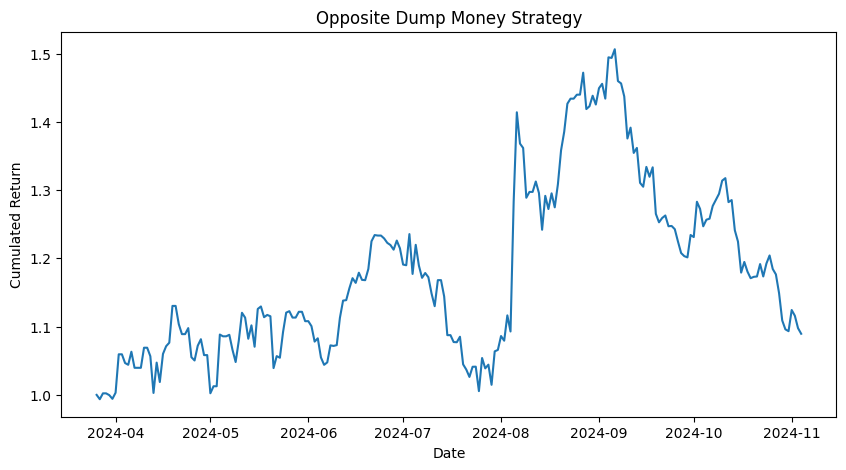

In [9]:
start_date = '2024-03-26'
date_range = pd.date_range(start=start_date, periods=len(df), freq='D')

df.index = date_range

plt.figure(figsize=(10,5))
plt.plot(date_range, df['cumulative_return'])
plt.xlabel('Date')
plt.ylabel('Cumulated Return')
plt.title('Opposite Dump Money Strategy')
plt.show()

In [10]:
# Calculate Sharpe
sharpe = (np.mean(df['daily_return']) / np.std(df['daily_return'])) * np.sqrt(365)
annulized_return = df['cumulative_return'].iloc[-1] ** (365/len(df)) - 1
print(f'The Total Trading Dates is: {len(df)} days \nThe Sharpe Ratio is: {sharpe:.4f} \nThe Annulized Return is: {annulized_return * 100:.2f}%')

cum_return_30 = []
for i in range(0,len(df)-30):
    tmp = 1
    for j in range(0,30):
        tmp = tmp * (1 + df['daily_return'].iloc[i+j])
    cum_return_30.append(tmp)
max_dd = -(min(cum_return_30)-1) * 100

print(f'The Maximum DrawDown in any 30-day period is: {max_dd:.2f}% \nThe Calmar Ratio equals to: {annulized_return / max_dd * 100:.4f}')

The Total Trading Dates is: 224 days 
The Sharpe Ratio is: 0.5241 
The Annulized Return is: 15.00%
The Maximum DrawDown in any 30-day period is: 18.20% 
The Calmar Ratio equals to: 0.8240


In [11]:
monthly_df = df.resample('ME').last()

for i in range(0,len(monthly_df)):
    if i == 0:
        monthly_df.loc[monthly_df.index[i],'monthly_return'] = monthly_df['cumulative_return'].iloc[i] - 1       
    else:
        monthly_df.loc[monthly_df.index[i],'monthly_return'] = monthly_df['cumulative_return'].iloc[i] / monthly_df['cumulative_return'].iloc[i-1] - 1

monthly_df['monthly_return']

2024-03-31   -0.005781
2024-04-30    0.064440
2024-05-31    0.046970
2024-06-30    0.096349
2024-07-31   -0.122537
2024-08-31    0.337293
2024-09-30   -0.134122
2024-10-31   -0.114139
2024-11-30   -0.003497
Freq: ME, Name: monthly_return, dtype: float64

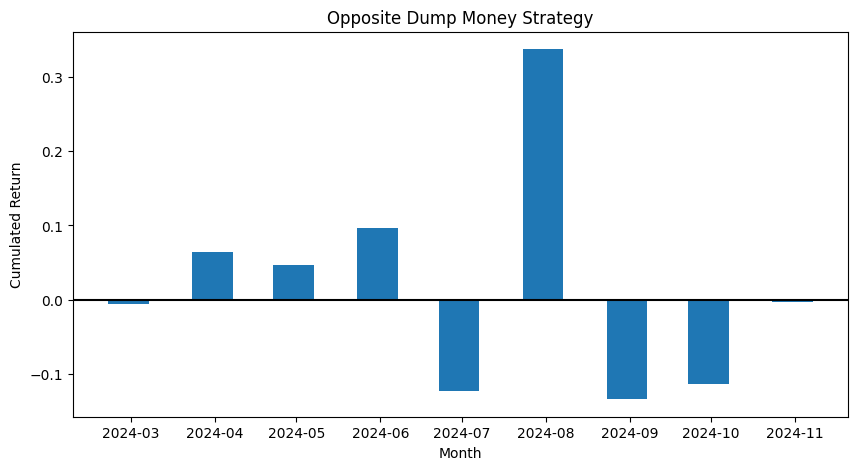

In [12]:
start_date = '2024-02'
date_range = pd.date_range(start=start_date, periods=len(monthly_df), freq='ME')

plt.figure(figsize=(10,5))
plt.bar(date_range, monthly_df['monthly_return'], width=15)
plt.axhline(y=0, color='black', linestyle='-', label='Baseline')
plt.xlabel('Month')
plt.ylabel('Cumulated Return')
plt.title('Opposite Dump Money Strategy')
plt.show()